# Magnetic field tools: Radia quadrupole example

## Imports

In [1]:
import sys
sys.path.append('../python/') 

import mag_field_tools as mft
import radia as rad

# %matplotlib notebook 
import matplotlib.pyplot as plt
import numpy as np
from math import pi, cos, sin

## Load a pre-computed Radia model

This model was build with the RadiaMM library (https://gitlab.esrf.fr/IDM/radia/radiamm)

In [ ]:
# Open
with open('quad_solved.rad', 'rb') as f:
    obj_bin = f.read()
    quad = rad.UtiDmpPrs(obj_bin)

In [37]:
# Plot the geometry
rad.ObjDrwOpenGL(quad)

12441

## Mag field tools parameters

In [4]:
# References
r0 = 7 # Reference radius
l0 = 1000 # 

# Number of points (2D)
n_theta = 32
n_coef = 16

# Number of points (3D)
n_theta_3d = 4 # for 1/8 of the magnet
n_l_3d = 64 # Number of points in the longitudinal direction 

## 2D multipoles

### Compute the field

Initialize SampleVectors...
Field computations with Radia...


Text(0, 0.5, 'Field int. (Tmm)')

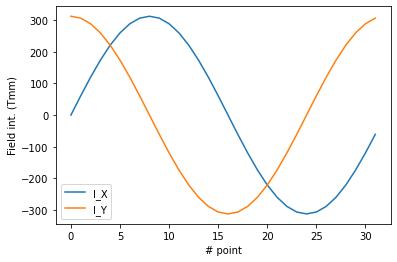

In [6]:
# Build a circle with radius r0
print('Initialize SampleVectors...')
circle = mft.SampleVector(['Tmm', 'mm'])
circle.samples_on_circle(r0, n_theta, 'x', False)
x, y = circle.get_coordinates('x'), circle.get_coordinates('y')

# Compute field integrals
print('Field computations with Radia...')
ix = [rad.FldInt(quad, 'inf', 'ibx', [x[k], - l0 / 2, y[k]], [x[k], l0 / 2, y[k]]) for k in range(n_theta)]
iy = [rad.FldInt(quad, 'inf', 'ibz', [x[k], - l0 / 2, y[k]], [x[k], l0 / 2, y[k]]) for k in range(n_theta)]
iz = [0 for k in range(n_theta)]
plt.figure()
plt.plot(ix, label='I_X')
plt.plot(iy, label='I_Y')
plt.legend()
plt.xlabel('# point')
plt.ylabel('Field int. (Tmm)')

### Compute the multipoles

In [38]:
# Store the field integrals in the sample vectors
print('Multipole computations...')
circle.set_vector_values(ix, iy, iz)

# Compute the multipoles
c = mft.Circular2D(r0, n_coef, circle)

# Print the results
c_coef = c.get_coef()
for k in range(n_coef):
    print('n =', k, ': bn =', np.real(c_coef[k]))

# Gradient
g = c.strength().get(1)
ug = g.get_unit_sample().get_symbol() # Gradient unit
print('\nNormal gradient: {0} {1}'.format(g.get_values()[0], ug))

Multipole computations...
n = 0 : bn = -7.915778033051879e-10
n = 1 : bn = 312.7150723802778
n = 2 : bn = 9.795716460203607e-10
n = 3 : bn = 7.056875639399607e-10
n = 4 : bn = 3.743379217713283e-09
n = 5 : bn = -0.04282308426681669
n = 6 : bn = -3.6230465294551095e-09
n = 7 : bn = -1.8322922068492176e-09
n = 8 : bn = -2.266579368637167e-09
n = 9 : bn = 0.013917690995808418
n = 10 : bn = -1.174194075304058e-09
n = 11 : bn = 5.381540102433746e-09
n = 12 : bn = -1.985783093516602e-09
n = 13 : bn = -0.015846625181016094
n = 14 : bn = -2.547437483180204e-09
n = 15 : bn = -1.5376633299979403e-10

Normal gradient: 44.67358176861111 T


### Compute the field from multipoles

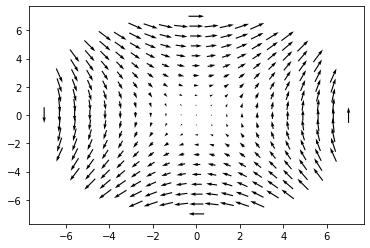

In [39]:
# Create samples on a disk
disk = mft.SampleVector(['Tmm', 'mm'])
disk.samples_on_disk(r0, 21, 'x', False)

# Compute the field
c.field(disk)

# Plot
x, y = disk.get_coordinates('x'), disk.get_coordinates('y')
ux, uy = disk.get_values('x'), disk.get_values('y')
plt.figure()
plt.quiver(x, y, ux, uy, pivot='middle')
plt.show()

### Move the multipole model

In [40]:
# Define and apply a translation
tr = mft.Translation([2, 0, 0])
c.move(tr)

# Compute and plot the field
c.field(disk)
x, y = disk.get_coordinates('x'), disk.get_coordinates('y')
ux, uy = disk.get_values('x'), disk.get_values('y')
plt.figure()
plt.quiver(x, y, ux, uy, pivot='middle')
plt.show()

# Back to initial position
c.move(mft.Translation([-2, 0, 0]))

## 3D Multipoles

### Compute the field with Radia

Field computations with Radia...
Compute 256 samples...


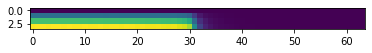

In [43]:
print('Field computations with Radia...')
print('Compute', n_theta_3d * n_l_3d, 'samples...')
# Define sample positions
xyz = [[0, 0, 0] for k in range(n_theta_3d * n_l_3d)]
idx = 0
for k in range(n_theta_3d):
    for l in range(n_l_3d):
        xyz[idx][0] = r0 * cos(pi / 4 * k / (n_theta_3d - 1))
        xyz[idx][1] = l * l0 / 2 / (n_l_3d - 1)
        xyz[idx][2] = r0 * sin(pi / 4 * k / (n_theta_3d - 1))
        idx += 1

# Compute the field
bx = rad.Fld(quad,'bx', xyz)
plt.figure()
plt.imshow(np.reshape(bx, (n_theta_3d, n_l_3d)))

### Create a set of samples and apply symmetries

In [44]:
# Extract the coordinates
n_3d = n_theta_3d * n_l_3d
x = [xyz[k][0] for k in range(n_3d)]
y = [xyz[k][2] for k in range(n_3d)]
z = [xyz[k][1] for k in range(n_3d)]

# Initialize a vector of samples with projected values
s = mft.SampleVector(n_3d)
s.set_coordinates(x, y, z)
zeros, ones = [0 for k in range(n_3d)], [1 for k in range(n_3d)]
s.set_unit_vector(ones, zeros, zeros)
s.set_values(bx)

# Apply symmetries
sym_z = mft.SymmetryPlaneZeroPerp([0, 0, 1])
s_sym_z = s.symmetry(sym_z)
s.add(s_sym_z)

sym_45 = mft.SymmetryPlaneZeroPerp([1, -1, 0])
s_sym_45 = s.symmetry(sym_45)
s.add(s_sym_45)

sym_x = mft.SymmetryPlaneZeroPara([1, 0, 0])
s_sym_x = s.symmetry(sym_x)
s.add(s_sym_x)

sym_y = mft.SymmetryPlaneZeroPara([0, 1, 0])
s_sym_y = s.symmetry(sym_y)
s.add(s_sym_y)

### Plot the field

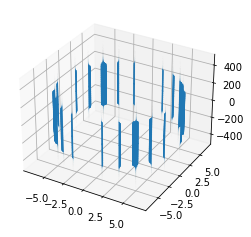

In [45]:
x, y, z = s.get_coordinates('x'), s.get_coordinates('y'), s.get_coordinates('z')
vx, vy, vz = s.get_vector_values('x'), s.get_vector_values('y'), s.get_vector_values('z')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.quiver(x, y, z, vx, vy, vz)  
plt.show()

### Compute the 3D multipoles

Text(0, 0.5, 'Quad. coef.')

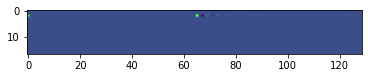

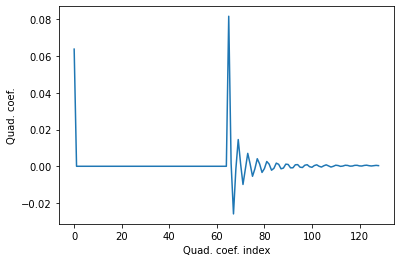

In [19]:
# Compute the multipoles
m = mft.Cylindrical3D(8, 64, r0, l0, s)

# Show all coefficients
plt.figure()
plt.imshow(m.get_coef())

# Plot the quadrupole coefficients
plt.figure()
plt.plot(m.get_coef()[2])
plt.xlabel('Quad. coef. index')
plt.ylabel('Quad. coef.')

### Compute the field from the multipoles

#### Field on a cylinder

In [46]:
# Initialize the samples
b = mft.SampleVector()
for rk in np.arange(1, r0+1):
    bk = mft.SampleVector()
    bk.samples_on_cylinder(float(rk), l0, 16, 64)
    bk.set_proj(False)
    b.add(bk)

In [47]:
# Define a threshold on coefficients to speed up the computations
m.set_coef_eps(1e-5)

In [48]:
# Compute the field
print('Compute', b.get_size(), 'samples...')
m.field(b)

Compute 7168 samples...


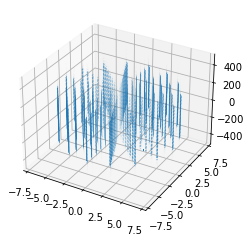

In [49]:
# Plot
x, y, z = b.get_coordinates('x'), b.get_coordinates('y'), b.get_coordinates('z')
bx, by, bz = b.get_vector_values('x'), b.get_vector_values('y'), b.get_vector_values('z')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.quiver(x, y, z, bx, by, bz)  
plt.show()